In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using Random

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
@model function hgf(real_k, real_w, z_variance, y_variance)
    
    xt_min_mean = datavar(Float64)
    xt_min_var  = datavar(Float64)
    
    zt_min_mean = datavar(Float64)
    zt_min_var  = datavar(Float64)
    
    xt_min ~ NormalMeanVariance(xt_min_mean, xt_min_var)
    zt_min ~ NormalMeanVariance(zt_min_mean, zt_min_var)
    
    zt ~ NormalMeanVariance(zt_min, z_variance) where { q = q(zt_min)q(z_variance)q(zt) }
    
    gcv_node, xt ~ GCV(xt_min, zt, real_k, real_w) where { q = q(xt, xt_min)q(zt)q(κ)q(ω) }
    
    y = datavar(Float64)
    
    y ~ NormalMeanVariance(xt, y_variance)
    
    return zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var
end

hgf (generic function with 1 method)

In [3]:
function inference(; data, iters, real_k, real_w, z_variance, y_variance)
    n = length(data)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler()
    
    mz = Vector{Marginal}()
    mx = Vector{Marginal}()
    fe = Vector{Float64}()

    model, (zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var) = hgf(real_k, real_w, z_variance, y_variance)

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (m) -> push!(mz, m))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (m) -> push!(mx, m))
    s_fe = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (f) -> push!(fe, f))
    
    # Initial prior messages
    current_zt = NormalMeanVariance(0.0, 10.0)
    current_xt = NormalMeanVariance(0.0, 10.0)

    # Prior marginals
    setmarginal!(gcv_node, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(gcv_node, :z, NormalMeanVariance(0.0, 5.0))
    
    for i in 1:n
        
        for _ in 1:iters
            update!(y, data[i])
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_var, var(current_zt))
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_var, var(current_xt))
            
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(s_fe)
    
    return mz, mx, fe
end

inference (generic function with 1 method)

In [4]:
n = 300
iters = 10

Random.seed!(229)

real_k = 1.0
real_w = -5.0

z_prev = 0.0
x_prev = 0.0

z = Vector{Float64}(undef, n)
v = Vector{Float64}(undef, n)
x = Vector{Float64}(undef, n)
y = Vector{Float64}(undef, n)

y_variance = 0.01
z_variance = 1.0

for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    v[i] = exp(real_k * z[i] + real_w)
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    y[i] = rand(Normal(x[i], sqrt(y_variance)))
    
    z_prev = z[i]
    x_prev = x[i]
end

In [36]:
@btime mz, mx, fe = inference(;
    data = y, 
    iters = iters, 
    real_k = real_k, 
    real_w = real_w, 
    z_variance = z_variance, 
    y_variance = y_variance
);

  97.489 ms (1177612 allocations: 54.17 MiB)


In [29]:
using Plots

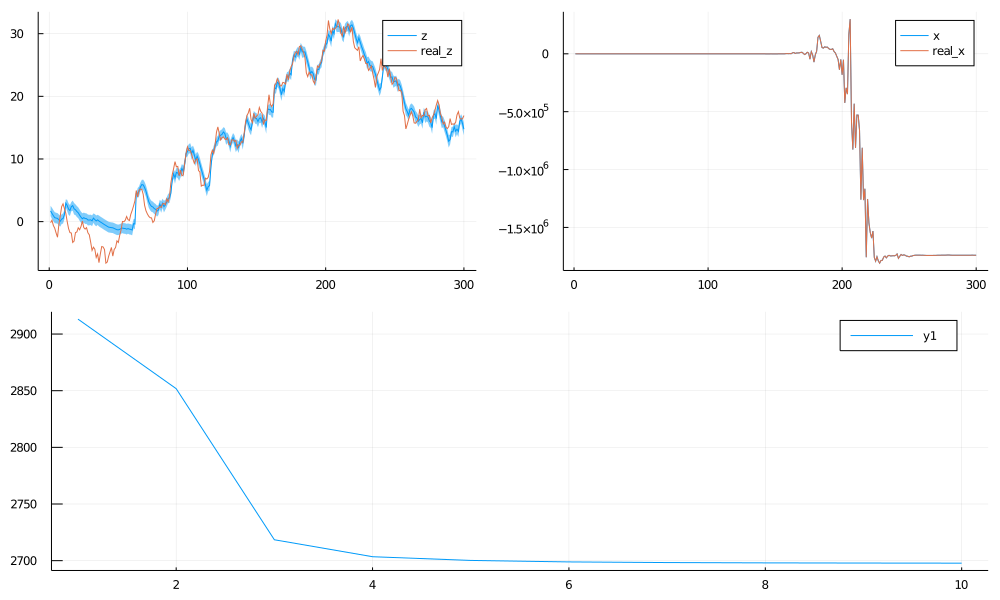

In [30]:
p1 = plot(mean.(mz), ribbon = std.(mz), label = "z")
p1 = plot!(p1, z, label = "real_z")

p2 = plot(mean.(mx), ribbon = std.(mx), label = "x")
p2 = plot!(p2, x, label = "real_x")

p3 = plot(vec(sum(reshape(fe, (iters, n)), dims = 2)))

plot(p1, p2, p3, layout = @layout([ a b; c ]), size = (1000, 600))